In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.viz_dl import *

In [11]:
root = Path("../results/custom_vs_orig")

# Load & parse the Jsons
def collect_results(dirpath: Path):
    files = sorted(dirpath.glob("*.json"))
    suf_re = re.compile(r'_(custom|orig)_split$', re.IGNORECASE)

    rows = []
    for p in files:
        base = p.stem
        m = suf_re.search(base)
        if not m:
            print(f"[skip] {p.name}: unknown suffix"); 
            continue
        model = base[:m.start()]
        split = m.group(1).capitalize()  # Custom / Orig
        with open(p, "r") as f:
            d = json.load(f)
        metr = d.get("test_metrics", d)
        rows.append({
            "Model": model,
            "Split": split,
            "Valence R²": float(metr["r2_v"]),
            "Arousal R²": float(metr["r2_a"]),
            "Valence RMSE": float(metr["rmse_v"]),
            "Arousal RMSE": float(metr["rmse_a"]),
        })
    if not rows:
        raise RuntimeError("No JSONs parsed. Check filenames/suffixes.")
    return pd.DataFrame(rows)

df = collect_results(root)

In [12]:
# Pivot (Model × Split) and sort by Orig R² (descending)
def pivot_metric(df, metric_col):
    piv = df.pivot(index="Model", columns="Split", values=metric_col)
    # ensure both columns present if possible
    cols = [c for c in ["Orig","Custom"] if c in piv.columns]
    piv = piv[cols]
    # sort by Orig if present, else by Custom
    sort_col = "Orig" if "Orig" in piv.columns else cols[0]
    return piv.sort_values(by=sort_col, ascending=False)

pv_v = pivot_metric(df, "Valence R²")
pv_a = pivot_metric(df, "Arousal R²")

In [13]:
# Clean horizontal bar plots (one figure per metric)
def plot_barh_pair(piv, title, savepath=None):
    h = max(4, 0.35 * len(piv))  # dynamic height
    ax = piv.plot(kind="barh", figsize=(10, h), width=0.82)
    ax.set_xlabel("R²")
    ax.set_ylabel("Model")
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    # annotate bars
    for c in ax.containers:
        ax.bar_label(c, fmt="%.3f", padding=3, fontsize=8)
    plt.tight_layout()
    if savepath:
        Path(savepath).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, bbox_inches="tight")
        print(f"saved: {savepath}")
    plt.show()

saved: ../results/mert/plots/custom_vs_orig_r2_valence.png


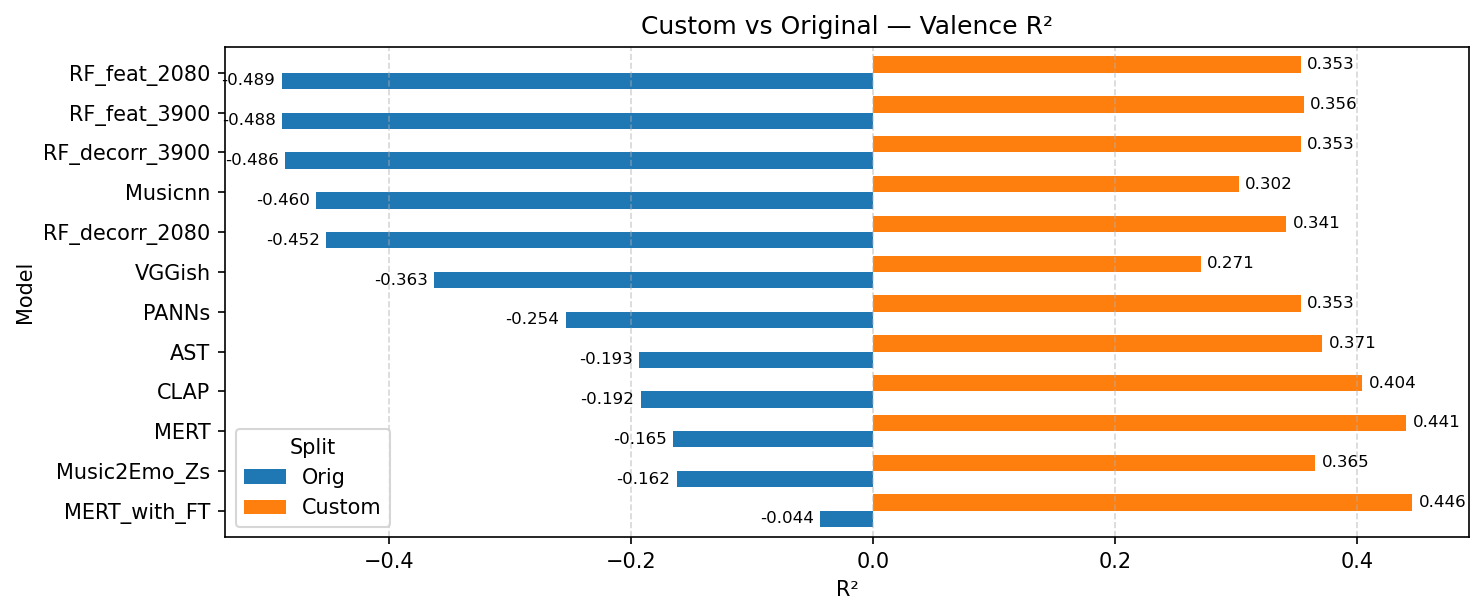

saved: ../results/mert/plots/custom_vs_orig_r2_arousal.png


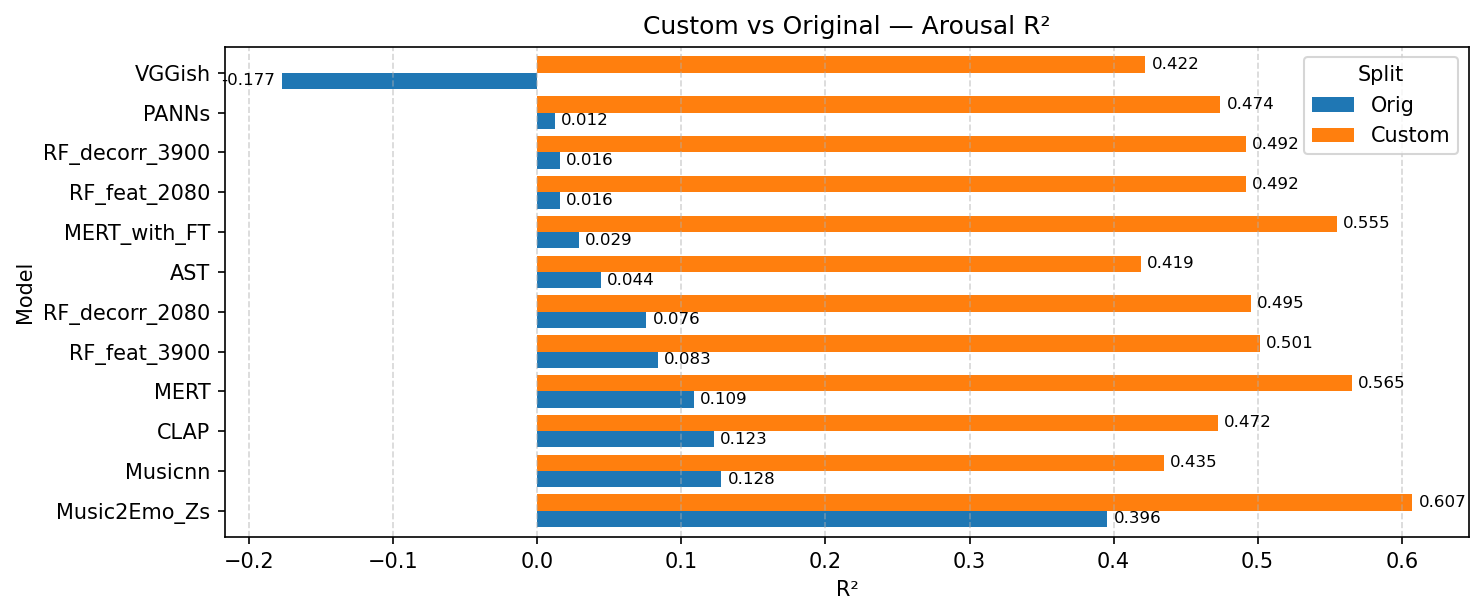

In [14]:
plot_barh_pair(pv_v, "Custom vs Original — Valence R²",
               "../results/mert/plots/custom_vs_orig_r2_valence.png")
plot_barh_pair(pv_a, "Custom vs Original — Arousal R²",
               "../results/mert/plots/custom_vs_orig_r2_arousal.png")

### comparison across models (custom split only)

In [16]:
import matplotlib.patches as mpatches

root = Path("../results/final_test_metrics")
outdir = root / "plots"
outdir.mkdir(parents=True, exist_ok=True)

rows = []
for p in sorted(root.glob("*.json")):
    base = p.stem
    model = base.removesuffix("_Custom_split")
    category = "Classic ML (RF)" if model.startswith("RF_") else "DL"
    with open(p, "r") as f:
        d = json.load(f)
    m = d.get("test_metrics", d)
    rows.append({
        "Model": model,
        "Category": category,
        "Valence R²": float(m["r2_v"]),
        "Arousal R²": float(m["r2_a"]),
        "Valence RMSE": float(m["rmse_v"]),
        "Arousal RMSE": float(m["rmse_a"]),
    })

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} models")

Loaded 16 models


In [20]:
def plot_custom_barh(df: pd.DataFrame, metric_col: str, title: str, savepath: Path):
    d = df.sort_values(metric_col, ascending=False).reset_index(drop=True)
    color_map = {"Classic ML (RF)": "#1f77b4", "DL": "#ff7f0e"}
    colors = d["Category"].map(color_map)

    h = max(4, 0.35 * len(d))
    fig, ax = plt.subplots(figsize=(9, h))
    ax.barh(d["Model"], d[metric_col], color=colors)
    ax.invert_yaxis()
    ax.set_xlabel("R²")
    ax.set_ylabel("Model")
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.5)

    # annotate
    for i, v in enumerate(d[metric_col].values):
        off = 3 if v >= 0 else -3
        ha = "left" if v >= 0 else "right"
        ax.annotate(f"{v:.3f}", xy=(v, i), xytext=(off, 0),
                    textcoords="offset points", va="center", ha=ha, fontsize=8)
    
    # add a bit of x-margin so labels don’t clip
    xmin, xmax = d[metric_col].min(), d[metric_col].max()
    ax.set_xlim(min(0, xmin) - 0.02, xmax + 0.05)

    # legend
    handles = [mpatches.Patch(color=color_map[k], label=k) for k in color_map]
    ax.legend(handles=handles, loc="lower right")

    plt.tight_layout()
    plt.savefig(savepath, bbox_inches="tight")
    print(f"saved: {savepath}")
    plt.show()

saved: ../results/final_test_metrics/plots/custom_only_r2_valence.png


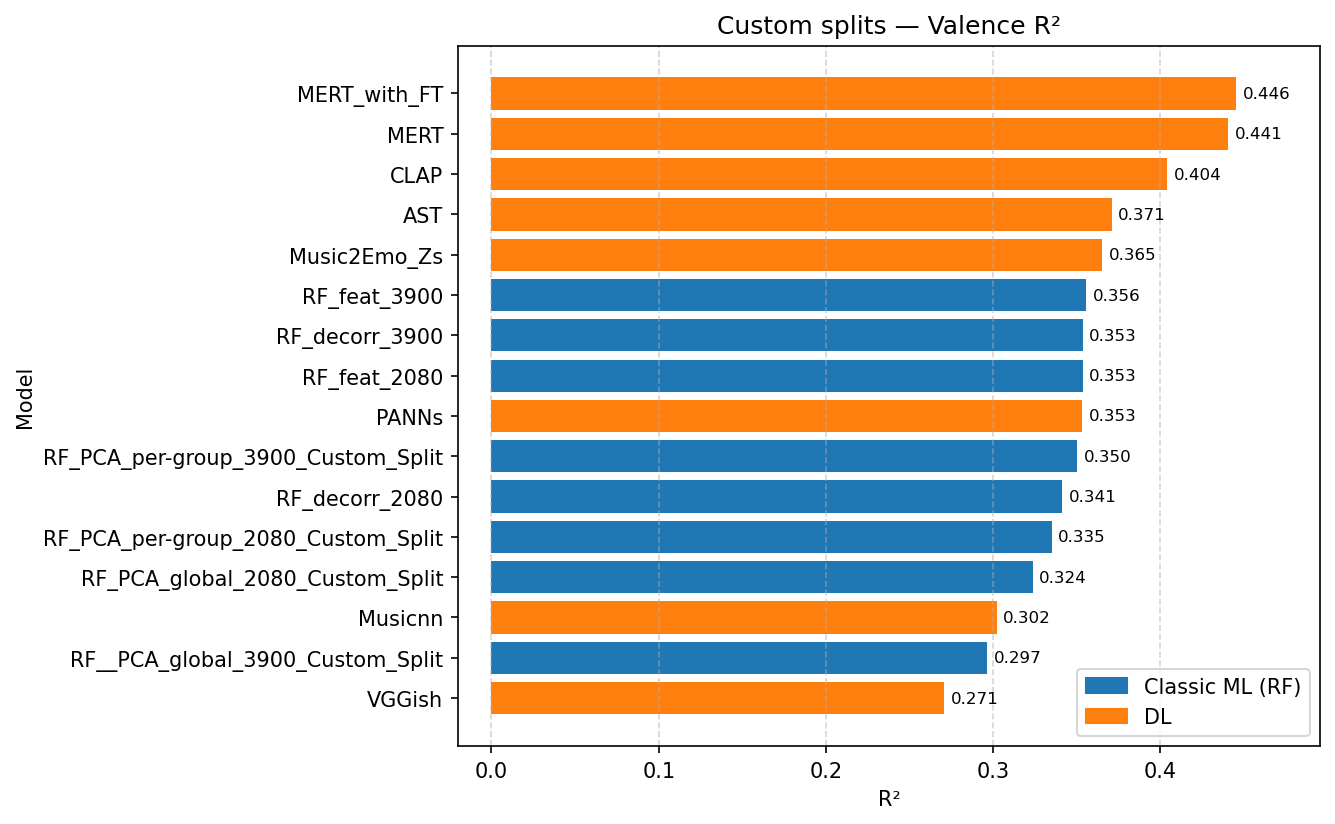

In [21]:
plot_custom_barh(df, "Valence R²", "Custom splits — Valence R²", outdir / "custom_only_r2_valence.png")

saved: ../results/final_test_metrics/plots/custom_only_r2_arousal.png


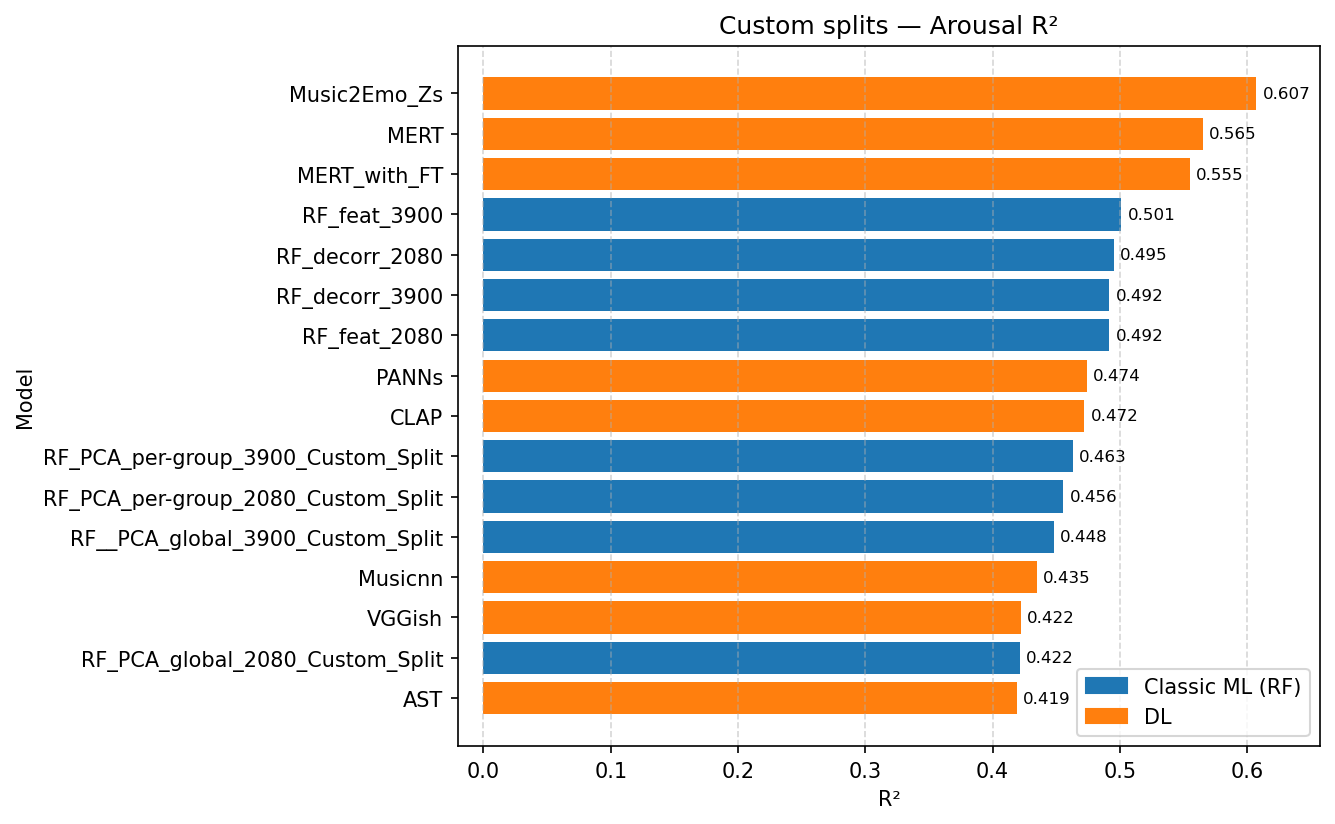

In [22]:
plot_custom_barh(df, "Arousal R²", "Custom splits — Arousal R²", outdir / "custom_only_r2_arousal.png")